## Máster en Big Data y Data Science

### Metodologías de gestión y diseño de proyectos de big data

#### AP2 - Descubrimiento de grupos en los datos

---

En esta libreta se generan los modelos de clusterización sobre el dataset final del escenario para su posterior evaluación y análisis. Se utilizará como herramienta de soporte a mlflow para el registro completo de la experimentación. 

---

In [1]:
# Importación de librerías

import pandas as pd
# Se importa mlflow para registro de la experimentación 
import mlflow
# Se importan los métodos a utilizar para clusterizar
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
# Otras opciones: DBSCAN, MeanShift, BisectingKMeans

# Se importan las métricas a utilizar para evaluar el proceso
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from mlflow.models.signature import infer_signature

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

seed =42 #Semilla para que los resultados sean reproducibles

----

##### Lectura del dataset

In [2]:
df = pd.read_csv("../../../data/final/datos_finales_clusterizacion.csv", sep=";")
df.head(5)

edad  importe_solicitado  duracion_credito  antiguedad_empleado  ingresos  \
0    21                1000                 2                  5.0      9600   
1    23               35000                 2                  4.0     65500   
2    24               35000                 4                  8.0     54400   
3    21                2500                 2                  2.0      9900   
4    26               35000                 3                  8.0     77100   

   pct_ingreso  tasa_interes  estado_credito  antiguedad_cliente  \
0         0.10         11.14               0                39.0   
1         0.53         15.23               1                36.0   
2         0.55         14.27               1                54.0   
3         0.25          7.14               1                34.0   
4         0.45         12.42               1                21.0   

   gastos_ult_12m  ...  estado_cliente_ACTIVO  estado_cliente_PASIVO  \
0          1144.0  ...                   True                  False   
1          1887.0  ...                   True                  False   
2          1314.0  ...                   True                  False   
3          1171.0  ...                   True                  False   
4           816.0  ...                   True                  False   

   genero_F  genero_M  nivel_educativo_DESCONOCIDO  \
0     False      True                        False   
1     False      True                        False   
2     False      True                         True   
3      True     False                        False   
4     False      True                        False   

   nivel_educativo_POSGRADO_COMPLETO  nivel_educativo_POSGRADO_INCOMPLETO  \
0                              False                                False   
1                              False                                False   
2                              False                                False   
3                              False                                False   
4                              False                                False   

   nivel_educativo_SECUNDARIO_COMPLETO  \
0                                 True   
1                                False   
2                                False   
3                                 True   
4                                False   

   nivel_educativo_UNIVERSITARIO_COMPLETO  \
0                                   False   
1                                    True   
2                                   False   
3                                   False   
4                                   False   

   nivel_educativo_UNIVERSITARIO_INCOMPLETO  
0                                     False  
1                                     False  
2                                     False  
3                                     False  
4                                      True  

[5 rows x 39 columns]

In [3]:
# Transformación por las características de mlflow para la detección de nulos en campos de tipo integer
df = df.astype({col: 'float64' for col in df.select_dtypes(include='int').columns})

----

##### Configuración de la experimentación

In [4]:
# Se genera el experimento en mlflow
exp_name = 'Experimentación clustering #1 (Por documentar - vf)'
exp_id = mlflow.create_experiment(name=exp_name)

In [5]:
# Por cada método se debe registrar la ejecución
with mlflow.start_run(experiment_id=exp_id, run_name="Kmeans - K=2"):
    # Selección y configuración de la técnica
    modelo_clusters = KMeans(n_clusters=2, random_state = seed)
    
    trained_model = modelo_clusters.fit(df)
    cluster_labels = trained_model.labels_

    # Se realizar el cálculo de las métricas seleccionadas
    score_s = silhouette_score(df, cluster_labels)
    score_db = davies_bouldin_score(df, cluster_labels)
    score_ch = calinski_harabasz_score(df, cluster_labels)

    # Se registra el parámetro K
    mlflow.log_param('Valor K', 2)

    # Se registran las métricas de evaluación
    mlflow.log_metric('silhouette_score', score_s)
    mlflow.log_metric('davies_bouldin_score', score_db)
    mlflow.log_metric('calinski_harabasz_score', score_ch)

    # Se guarda el modelo generado
    input_example = df.iloc[0].to_frame().T
    signature = infer_signature(df, cluster_labels)
    mlflow.sklearn.log_model(trained_model, "Kmeans_K2", input_example=input_example, signature=signature)

    # Se finaliza el registro
    mlflow.end_run()

2025/05/07 13:11:56 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Para contabilizar los elementos por cluster se utilizan las labels generadas

In [6]:
# Se preserva el conjunto de datos original para evitar problemas
df_kmeans_k2 = df.copy()
# Se agregan las labels generadas
df_kmeans_k2['cluster'] = cluster_labels
df_kmeans_k2['cluster'].value_counts()

cluster
0    8276
1     602
Name: count, dtype: int64

Visualización de los resultados en 2D usando PCA.

c:\Users\Vero\Desktop\13MBID-OCT24-25\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


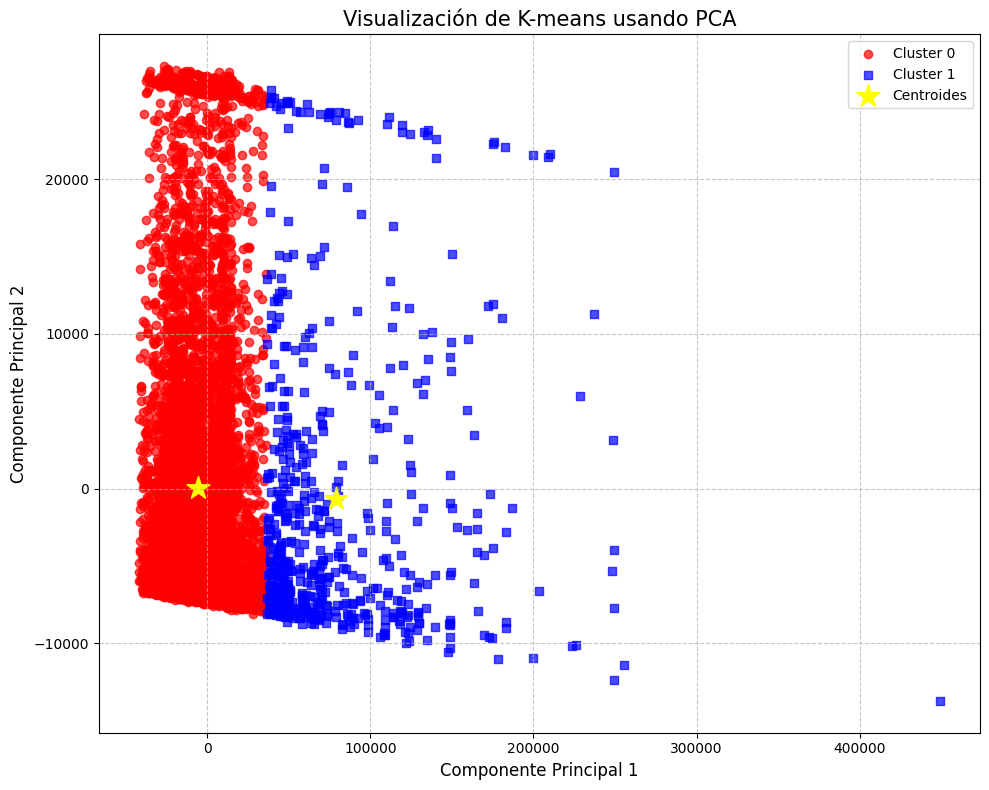

In [7]:
# Preparar los datos para PCA - solo usamos PCA para visualización
# Excluir la columna 'cluster' para el escalado
X = df_kmeans_k2.drop('cluster', axis=1)

# Aplicar PCA para reducir a 2 dimensiones (solo para visualización)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

# Crear un DataFrame con los componentes principales
principal_df = pd.DataFrame(data=principalComponents, 
                           columns=['PC1', 'PC2'])

# Añadir la columna de cluster que ya teníamos
principal_df['cluster'] = df_kmeans_k2['cluster']

# Visualizar los resultados proyectados en el espacio PCA
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange']
markers = ['o', 's', '^', 'D', 'v']

for i, color, marker in zip(range(len(np.unique(df_kmeans_k2['cluster']))), colors, markers):
    plt.scatter(principal_df.loc[principal_df['cluster'] == i, 'PC1'],
                principal_df.loc[principal_df['cluster'] == i, 'PC2'],
                c=color, marker=marker, label=f'Cluster {i}', alpha=0.7)

# Añadir centroides de K-means transformados al espacio PCA
centroids = pca.transform(modelo_clusters.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='yellow', marker='*', label='Centroides')


plt.title('Visualización de K-means usando PCA', fontsize=15)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Registrar la visualización en MLflow
with mlflow.start_run(experiment_id=exp_id, run_name="Kmeans_K2_PCA_Visualization"):
    # Guardar la figura
    plt.savefig("../../../docs/graficos_modelado_clusterizacion/kmeans_k2_pca_visualization.png")
    mlflow.log_artifact("../../../docs/graficos_modelado_clusterizacion/kmeans_k2_pca_visualization.png", "visualizations")
    
    mlflow.end_run()

plt.show()


Se pasa a probar otro método (clustering jerárquico)

In [8]:
# Por cada método se debe registrar la ejecución
with mlflow.start_run(experiment_id=exp_id, run_name="AGClustering - K=2"):
    # Selección y configuración de la técnica
    modelo_clusters = AgglomerativeClustering(n_clusters=2)
    
    trained_model = modelo_clusters.fit(df)
    cluster_labels = trained_model.labels_

    # Se realizar el cálculo de las métricas seleccionadas
    score_s = silhouette_score(df, cluster_labels)
    score_db = davies_bouldin_score(df, cluster_labels)
    score_ch = calinski_harabasz_score(df, cluster_labels)

    # Se registra el parámetro K
    mlflow.log_param('Valor K', 2)

    # Se registran las métricas de evaluación
    mlflow.log_metric('silhouette_score', score_s)
    mlflow.log_metric('davies_bouldin_score', score_db)
    mlflow.log_metric('calinski_harabasz_score', score_ch)

    # Se guarda el modelo generado
    # input_example = df.iloc[0].to_frame().T
    signature = infer_signature(df, cluster_labels)
    mlflow.sklearn.log_model(trained_model, "AGC_2", signature=signature)

    # Se finaliza el registro
    mlflow.end_run()

2025/05/07 13:12:14 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/05/07 13:12:22 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Para contabilizar los elementos por cluster se utilizan las labels generadas

In [9]:
# Se preserva el conjunto de datos original para evitar problemas
df_agc_k2 = df.copy()
# Se agregan las labels generadas
df_agc_k2['cluster'] = cluster_labels
df_agc_k2['cluster'].value_counts()

cluster
0    8508
1     370
Name: count, dtype: int64

Se visualizan los resultado en 2D mediante PCA

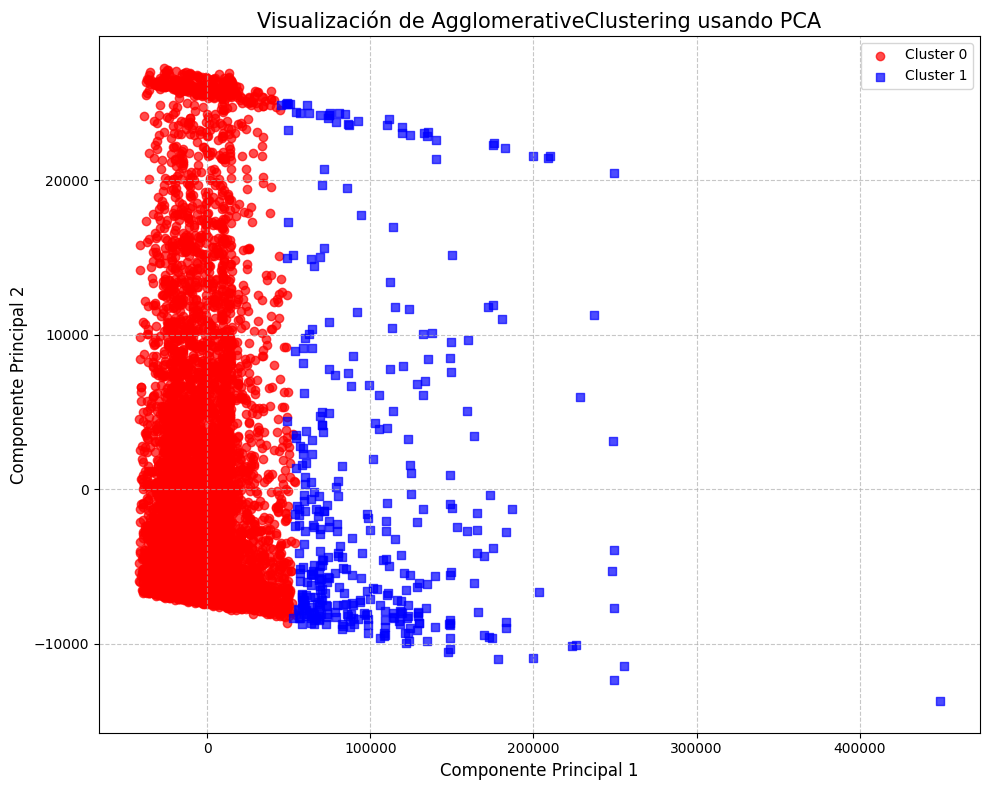

In [10]:
# Preparar los datos para PCA - solo usamos PCA para visualización
# Excluir la columna 'cluster' para el escalado
X = df_agc_k2.drop('cluster', axis=1)

# Aplicar PCA para reducir a 2 dimensiones (solo para visualización)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

# Crear un DataFrame con los componentes principales
principal_df = pd.DataFrame(data=principalComponents, 
                           columns=['PC1', 'PC2'])

# Añadir la columna de cluster que ya teníamos
principal_df['cluster'] = df_agc_k2['cluster']

# Visualizar los resultados proyectados en el espacio PCA
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange']
markers = ['o', 's', '^', 'D', 'v']

for i, color, marker in zip(range(len(np.unique(df_agc_k2['cluster']))), colors, markers):
    plt.scatter(principal_df.loc[principal_df['cluster'] == i, 'PC1'],
                principal_df.loc[principal_df['cluster'] == i, 'PC2'],
                c=color, marker=marker, label=f'Cluster {i}', alpha=0.7)

plt.title('Visualización de AgglomerativeClustering usando PCA', fontsize=15)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Registrar la visualización en MLflow
with mlflow.start_run(experiment_id=exp_id, run_name="agc_K2_PCA_Visualization"):
    # Guardar la figura
    plt.savefig("../../../docs/graficos_modelado_clusterizacion/agc_k2_pca_visualization.png")
    mlflow.log_artifact("../../../docs/graficos_modelado_clusterizacion/agc_k2_pca_visualization.png", "visualizations")
    
    mlflow.end_run()

plt.show()

Se realiza la exportación de los resultados

In [ ]:
#df_agc_k2.to_csv("../../../data/final/df_agc_k2.csv", sep=";", index=False)

Prueba con otro método paramétrico

In [11]:
with mlflow.start_run(experiment_id=exp_id, run_name="Birch - K = 2"):
    modelo_clusters = Birch(n_clusters=2)
    trained_model = modelo_clusters.fit(df)
    cluster_labels = trained_model.labels_

    # Calcular métricas
    score_s = silhouette_score(df, cluster_labels)
    score_db = davies_bouldin_score(df, cluster_labels)
    score_ch = calinski_harabasz_score(df, cluster_labels)

    # Se registra el parámetro K
    mlflow.log_param('Valor K', 2)

    # Registrar métricas
    mlflow.log_metric('silhouette_score', score_s)
    mlflow.log_metric('davies_bouldin_score', score_db)
    mlflow.log_metric('calinski_harabasz_score', score_ch)

    # Guardar el modelo
    signature = infer_signature(df, cluster_labels)
    mlflow.sklearn.log_model(trained_model, "Birch_Model", signature=signature)

    mlflow.end_run()

2025/05/07 13:12:46 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


In [12]:
# Se preserva el conjunto de datos original para evitar problemas
df_bc = df.copy()
# Se agregan las labels generadas
df_bc['cluster'] = cluster_labels
df_bc['cluster'].value_counts()

cluster
0    8508
1     370
Name: count, dtype: int64

Se visualizan los resultados en 2D con PCA

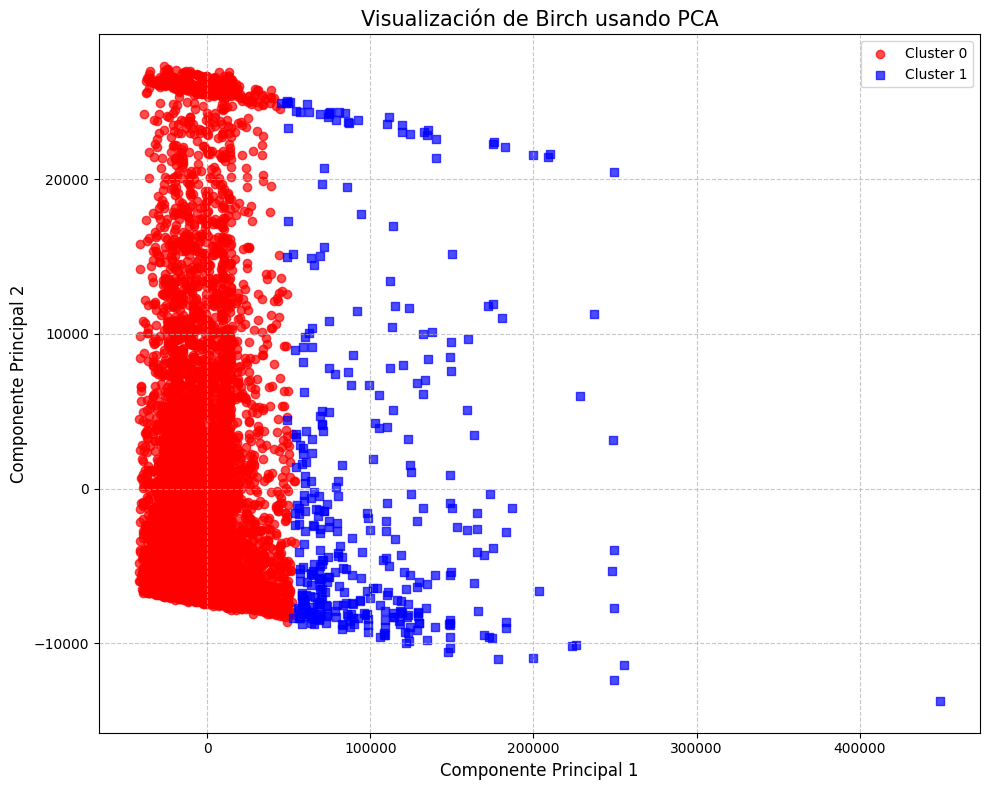

In [13]:
# Preparar los datos para PCA - solo usamos PCA para visualización
# Excluir la columna 'cluster' para el escalado
X = df_bc.drop('cluster', axis=1)


# Aplicar PCA para reducir a 2 dimensiones (solo para visualización)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

# Crear un DataFrame con los componentes principales
principal_df = pd.DataFrame(data=principalComponents, 
                           columns=['PC1', 'PC2'])

# Añadir la columna de cluster que ya teníamos
principal_df['cluster'] = df_bc['cluster']

# Visualizar los resultados proyectados en el espacio PCA
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange']
markers = ['o', 's', '^', 'D', 'v']

for i, color, marker in zip(range(len(np.unique(df_bc['cluster']))), colors, markers):
    plt.scatter(principal_df.loc[principal_df['cluster'] == i, 'PC1'],
                principal_df.loc[principal_df['cluster'] == i, 'PC2'],
                c=color, marker=marker, label=f'Cluster {i}', alpha=0.7)

plt.title('Visualización de Birch usando PCA', fontsize=15)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Registrar la visualización en MLflow
with mlflow.start_run(experiment_id=exp_id, run_name="bc_K2_PCA_Visualization"):
    # Guardar la figura
    plt.savefig("../../../docs/graficos_modelado_clusterizacion/bc_k2_pca_visualization.png")
    mlflow.log_artifact("../../../docs/graficos_modelado_clusterizacion/bc_k2_pca_visualization.png", "visualizations")
    
    mlflow.end_run()

plt.show()

Se prueba con Kmeans pero con K = 3

Para contabilizar los elementos por cluster se utilizan las labels generadas

In [14]:
# Por cada método se debe registrar la ejecución
with mlflow.start_run(experiment_id=exp_id, run_name="Kmeans - K=3"):
    # Selección y configuración de la técnica
    modelo_clusters = KMeans(n_clusters=3, random_state = seed)
    
    trained_model = modelo_clusters.fit(df)
    cluster_labels = trained_model.labels_

    # Se realizar el cálculo de las métricas seleccionadas
    score_s = silhouette_score(df, cluster_labels)
    score_db = davies_bouldin_score(df, cluster_labels)
    score_ch = calinski_harabasz_score(df, cluster_labels)

    # Se registra el parámetro K
    mlflow.log_param('Valor K', 3)

    # Se registran las métricas de evaluación
    mlflow.log_metric('silhouette_score', score_s)
    mlflow.log_metric('davies_bouldin_score', score_db)
    mlflow.log_metric('calinski_harabasz_score', score_ch)

    # Se guarda el modelo generado
    input_example = df.iloc[0].to_frame().T
    signature = infer_signature(df, cluster_labels)
    mlflow.sklearn.log_model(trained_model, "Kmeans_K3", input_example=input_example, signature=signature)

    # Se finaliza el registro
    mlflow.end_run()

2025/05/07 13:13:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


In [15]:
# Se preserva el conjunto de datos original para evitar problemas
df_kms_k3 = df.copy()
# Se agregan las labels generadas
df_kms_k3['cluster'] = cluster_labels
df_kms_k3['cluster'].value_counts()

cluster
0    4701
1    3872
2     305
Name: count, dtype: int64

Se visualizan los resultados

c:\Users\Vero\Desktop\13MBID-OCT24-25\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


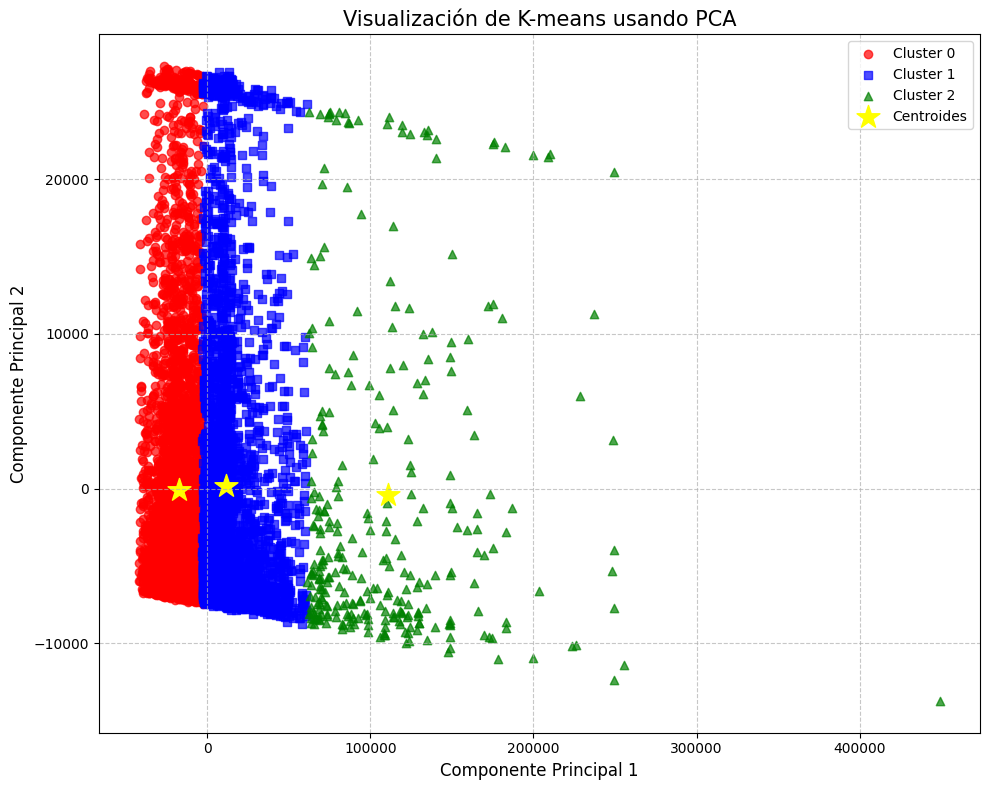

In [16]:
# Preparar los datos para PCA - solo usamos PCA para visualización
# Excluir la columna 'cluster' para el escalado
X = df_kms_k3.drop('cluster', axis=1)

# Aplicar PCA para reducir a 2 dimensiones (solo para visualización)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

# Crear un DataFrame con los componentes principales
principal_df = pd.DataFrame(data=principalComponents, 
                           columns=['PC1', 'PC2'])

# Añadir la columna de cluster que ya teníamos
principal_df['cluster'] = df_kms_k3['cluster']

# Visualizar los resultados proyectados en el espacio PCA
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange']
markers = ['o', 's', '^', 'D', 'v']

for i, color, marker in zip(range(len(np.unique(df_kms_k3['cluster']))), colors, markers):
    plt.scatter(principal_df.loc[principal_df['cluster'] == i, 'PC1'],
                principal_df.loc[principal_df['cluster'] == i, 'PC2'],
                c=color, marker=marker, label=f'Cluster {i}', alpha=0.7)

# Añadir centroides de K-means transformados al espacio PCA
centroids = pca.transform(modelo_clusters.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='yellow', marker='*', label='Centroides')


plt.title('Visualización de K-means usando PCA', fontsize=15)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Registrar la visualización en MLflow
with mlflow.start_run(experiment_id=exp_id, run_name="Kmeans_K3_PCA_Visualization"):
    # Guardar la figura
    plt.savefig("../../../docs/graficos_modelado_clusterizacion/kmeans_k3_pca_visualization.png")
    mlflow.log_artifact("../../../docs/graficos_modelado_clusterizacion/kmeans_k3_pca_visualization.png", "visualizations")
    
    mlflow.end_run()

plt.show()


Se prueba con AGC para k=3

In [17]:
# Por cada método se debe registrar la ejecución
with mlflow.start_run(experiment_id=exp_id, run_name="AGClustering - K=3"):
    # Selección y configuración de la técnica
    modelo_clusters = AgglomerativeClustering(n_clusters=3)
    
    trained_model = modelo_clusters.fit(df)
    cluster_labels = trained_model.labels_

    # Se realizar el cálculo de las métricas seleccionadas
    score_s = silhouette_score(df, cluster_labels)
    score_db = davies_bouldin_score(df, cluster_labels)
    score_ch = calinski_harabasz_score(df, cluster_labels)

    # Se registra el parámetro K
    mlflow.log_param('Valor K', 3)

    # Se registran las métricas de evaluación
    mlflow.log_metric('silhouette_score', score_s)
    mlflow.log_metric('davies_bouldin_score', score_db)
    mlflow.log_metric('calinski_harabasz_score', score_ch)

    # Se guarda el modelo generado
    # input_example = df.iloc[0].to_frame().T
    signature = infer_signature(df, cluster_labels)
    mlflow.sklearn.log_model(trained_model, "AGC_3", signature=signature)

    # Se finaliza el registro
    mlflow.end_run()

2025/05/07 13:13:22 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/05/07 13:13:30 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


In [18]:
# Se preserva el conjunto de datos original para evitar problemas
df_agc_k3 = df.copy()
# Se agregan las labels generadas
df_agc_k3['cluster'] = cluster_labels
df_agc_k3['cluster'].value_counts()

cluster
0    4558
2    3950
1     370
Name: count, dtype: int64

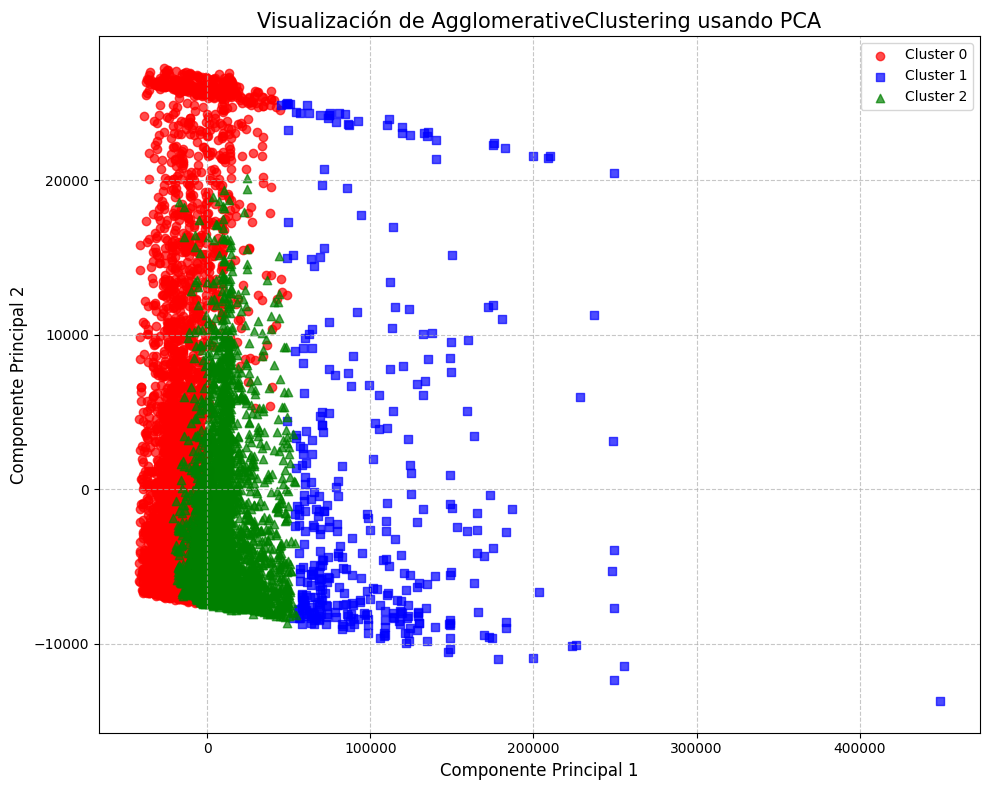

In [19]:
# Preparar los datos para PCA - solo usamos PCA para visualización
# Excluir la columna 'cluster' para el escalado
X = df_agc_k3.drop('cluster', axis=1)

# Aplicar PCA para reducir a 2 dimensiones (solo para visualización)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

# Crear un DataFrame con los componentes principales
principal_df = pd.DataFrame(data=principalComponents, 
                           columns=['PC1', 'PC2'])

# Añadir la columna de cluster que ya teníamos
principal_df['cluster'] = df_agc_k3['cluster']

# Visualizar los resultados proyectados en el espacio PCA
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange']
markers = ['o', 's', '^', 'D', 'v']

for i, color, marker in zip(range(len(np.unique(df_agc_k3['cluster']))), colors, markers):
    plt.scatter(principal_df.loc[principal_df['cluster'] == i, 'PC1'],
                principal_df.loc[principal_df['cluster'] == i, 'PC2'],
                c=color, marker=marker, label=f'Cluster {i}', alpha=0.7)

plt.title('Visualización de AgglomerativeClustering usando PCA', fontsize=15)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Registrar la visualización en MLflow
with mlflow.start_run(experiment_id=exp_id, run_name="agc_K3_PCA_Visualization"):
    # Guardar la figura
    plt.savefig("../../../docs/graficos_modelado_clusterizacion/agc_k3_pca_visualization.png")
    mlflow.log_artifact("../../../docs/graficos_modelado_clusterizacion/agc_k3_pca_visualization.png", "visualizations")
    
    mlflow.end_run()

plt.show()

Se prueba con el algoritmo Birch para k=3

In [20]:
with mlflow.start_run(experiment_id=exp_id, run_name="Birch - K = 3"):
    modelo_clusters = Birch(n_clusters=3)
    trained_model = modelo_clusters.fit(df)
    cluster_labels = trained_model.labels_

    # Calcular métricas
    score_s = silhouette_score(df, cluster_labels)
    score_db = davies_bouldin_score(df, cluster_labels)
    score_ch = calinski_harabasz_score(df, cluster_labels)

    # Se registra el parámetro K
    mlflow.log_param('Valor K', 3)

    # Registrar métricas
    mlflow.log_metric('silhouette_score', score_s)
    mlflow.log_metric('davies_bouldin_score', score_db)
    mlflow.log_metric('calinski_harabasz_score', score_ch)

    # Guardar el modelo
    signature = infer_signature(df, cluster_labels)
    mlflow.sklearn.log_model(trained_model, "Birch_Model", signature=signature)

    mlflow.end_run()

2025/05/07 13:13:54 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


In [21]:
# Se preserva el conjunto de datos original para evitar problemas
df_bc_k3 = df.copy()
# Se agregan las labels generadas
df_bc_k3['cluster'] = cluster_labels
df_bc_k3['cluster'].value_counts()

cluster
0    4558
2    3950
1     370
Name: count, dtype: int64

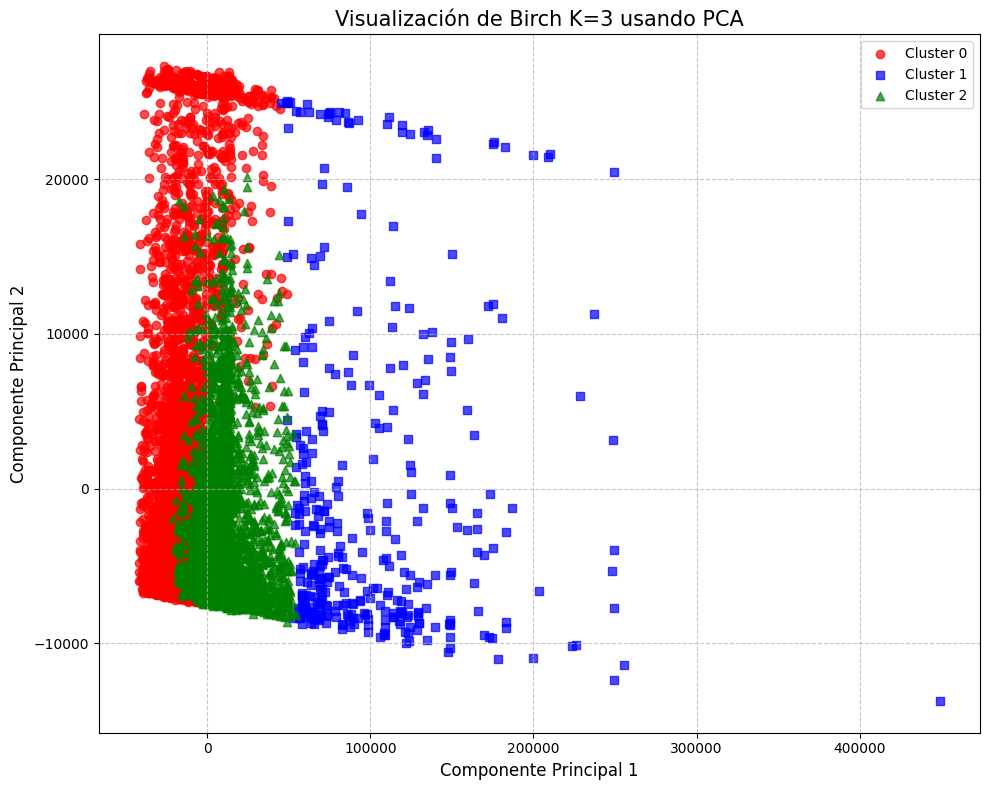

In [22]:
# Preparar los datos para PCA - solo usamos PCA para visualización
# Excluir la columna 'cluster' para el escalado
X = df_bc_k3.drop('cluster', axis=1)

# Aplicar PCA para reducir a 2 dimensiones (solo para visualización)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

# Crear un DataFrame con los componentes principales
principal_df = pd.DataFrame(data=principalComponents, 
                           columns=['PC1', 'PC2'])

# Añadir la columna de cluster que ya teníamos
principal_df['cluster'] = df_bc_k3['cluster']

# Visualizar los resultados proyectados en el espacio PCA
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange']
markers = ['o', 's', '^', 'D', 'v']

for i, color, marker in zip(range(len(np.unique(df_bc_k3['cluster']))), colors, markers):
    plt.scatter(principal_df.loc[principal_df['cluster'] == i, 'PC1'],
                principal_df.loc[principal_df['cluster'] == i, 'PC2'],
                c=color, marker=marker, label=f'Cluster {i}', alpha=0.7)

plt.title('Visualización de Birch K=3 usando PCA', fontsize=15)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Registrar la visualización en MLflow
with mlflow.start_run(experiment_id=exp_id, run_name="bc_K3_PCA_Visualization"):
    # Guardar la figura
    plt.savefig("../../../docs/graficos_modelado_clusterizacion/bc_k3_pca_visualization.png")
    mlflow.log_artifact("../../../docs/graficos_modelado_clusterizacion/bc_k3_pca_visualization.png", "visualizations")
    
    mlflow.end_run()

plt.show()

### Opciones de optimización del proceso

Utilizar PCA (solo para visualización de clusters) y un proceso de normalización de valores para eliminar el impacto de las diferencias en el dataset en la clusterización.

Prueba #2

In [23]:
# Normalización de los datos
scaler = StandardScaler()
df_normalizado = scaler.fit_transform(df)


In [24]:
# Se genera el experimento en mlflow
exp_name = 'Experimentación clustering #2 (Por documentar - vf)'
exp_id = mlflow.create_experiment(name=exp_name)

In [25]:
# Por cada método se debe registrar la ejecución
with mlflow.start_run(experiment_id=exp_id, run_name="Kmeans N - K=2"):
    # Selección y configuración de la técnica
    modelo_clusters = KMeans(n_clusters=2, random_state = seed)
    
    trained_model = modelo_clusters.fit(df_normalizado)
    cluster_labels = trained_model.labels_

    # Se realizar el cálculo de las métricas seleccionadas
    score_s = silhouette_score(df_normalizado, cluster_labels)
    score_db = davies_bouldin_score(df_normalizado, cluster_labels)
    score_ch = calinski_harabasz_score(df_normalizado, cluster_labels)

    # Se registra el parámetro K
    mlflow.log_param('Valor K', 2)

    # Se registran las métricas de evaluación
    mlflow.log_metric('silhouette_score', score_s)
    mlflow.log_metric('davies_bouldin_score', score_db)
    mlflow.log_metric('calinski_harabasz_score', score_ch)

    # Se guarda el modelo generado
    # input_example = df_normalizado.iloc[0].to_frame().T
    signature = infer_signature(df_normalizado, cluster_labels)
    mlflow.sklearn.log_model(trained_model, "Kmeans_K2_N", input_example=input_example, signature=signature)

    # Se finaliza el registro
    mlflow.end_run()

2025/05/07 13:23:22 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


In [26]:
# Se preserva el conjunto de datos original para evitar problemas
# Convertir df_normalizado a un DataFrame de pandas
df_kms_k2_n = pd.DataFrame(df_normalizado, columns=df.columns)

# Se agregan las labels generadas
df_kms_k2_n['cluster'] = cluster_labels

# Contar los elementos por cluster
df_kms_k2_n['cluster'].value_counts()

cluster
1    6850
0    2028
Name: count, dtype: int64

c:\Users\Vero\Desktop\13MBID-OCT24-25\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


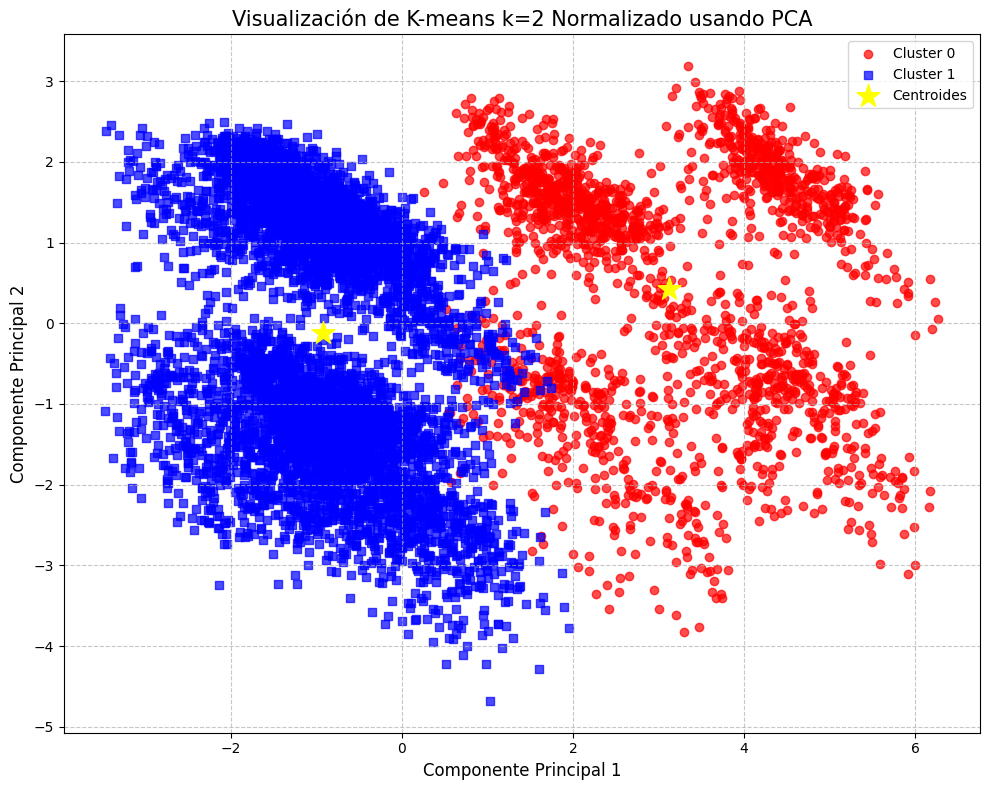

In [27]:
# Preparar los datos para PCA - solo usamos PCA para visualización
# Excluir la columna 'cluster' para el escalado
X = df_kms_k2_n.drop('cluster', axis=1)

# Aplicar PCA para reducir a 2 dimensiones (solo para visualización)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

# Crear un DataFrame con los componentes principales
principal_df = pd.DataFrame(data=principalComponents, 
                           columns=['PC1', 'PC2'])

# Añadir la columna de cluster que ya teníamos
principal_df['cluster'] = df_kms_k2_n['cluster']

# Visualizar los resultados proyectados en el espacio PCA
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange']
markers = ['o', 's', '^', 'D', 'v']

for i, color, marker in zip(range(len(np.unique(df_kms_k2_n['cluster']))), colors, markers):
    plt.scatter(principal_df.loc[principal_df['cluster'] == i, 'PC1'],
                principal_df.loc[principal_df['cluster'] == i, 'PC2'],
                c=color, marker=marker, label=f'Cluster {i}', alpha=0.7)

# Añadir centroides de K-means transformados al espacio PCA
centroids = pca.transform(modelo_clusters.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='yellow', marker='*', label='Centroides')


plt.title('Visualización de K-means k=2 Normalizado usando PCA', fontsize=15)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Registrar la visualización en MLflow
with mlflow.start_run(experiment_id=exp_id, run_name="Kmeans_K2_N_PCA_Visualization"):
    # Guardar la figura
    plt.savefig("../../../docs/graficos_modelado_clusterizacion/kmeans_k2_N_pca_visualization.png")
    mlflow.log_artifact("../../../docs/graficos_modelado_clusterizacion/kmeans_k2_N_pca_visualization.png", "visualizations")
    
    mlflow.end_run()

plt.show()

In [28]:
# Por cada método se debe registrar la ejecución
with mlflow.start_run(experiment_id=exp_id, run_name="AGClustering N - K=2"):
    # Selección y configuración de la técnica
    modelo_clusters = AgglomerativeClustering(n_clusters=2)
    
    trained_model = modelo_clusters.fit(df_normalizado)
    cluster_labels = trained_model.labels_

    # Se realizar el cálculo de las métricas seleccionadas
    score_s = silhouette_score(df_normalizado, cluster_labels)
    score_db = davies_bouldin_score(df_normalizado, cluster_labels)
    score_ch = calinski_harabasz_score(df_normalizado, cluster_labels)

    # Se registra el parámetro K
    mlflow.log_param('Valor K', 2)

    # Se registran las métricas de evaluación
    mlflow.log_metric('silhouette_score', score_s)
    mlflow.log_metric('davies_bouldin_score', score_db)
    mlflow.log_metric('calinski_harabasz_score', score_ch)

    # Se guarda el modelo generado
    # input_example = df_normalizado.iloc[0].to_frame().T
    signature = infer_signature(df_normalizado, cluster_labels)
    mlflow.sklearn.log_model(trained_model, "AGC_2_N", signature=signature)

    # Se finaliza el registro
    mlflow.end_run()

2025/05/07 13:24:14 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/05/07 13:24:24 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


In [29]:
# Se preserva el conjunto de datos original para evitar problemas
df_agc_k2_n = pd.DataFrame(df_normalizado, columns=df.columns)
# Se agregan las labels generadas
df_agc_k2_n['cluster'] = cluster_labels
df_agc_k2_n['cluster'].value_counts()

cluster
0    7255
1    1623
Name: count, dtype: int64

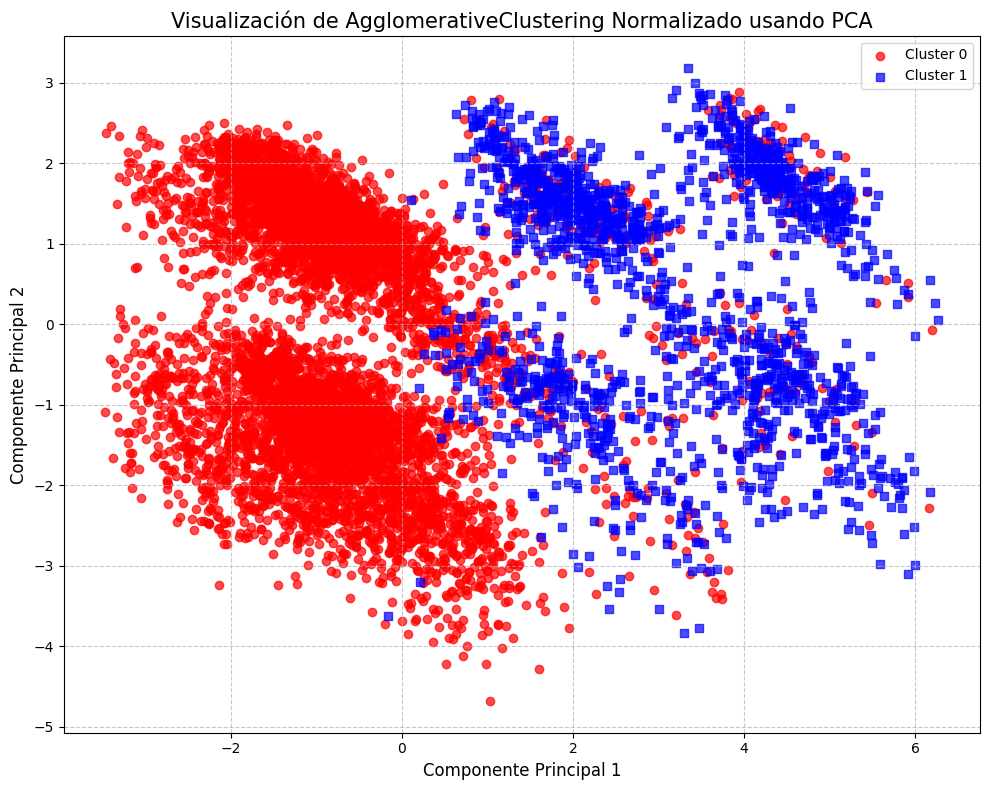

In [30]:
# Preparar los datos para PCA - solo usamos PCA para visualización
# Excluir la columna 'cluster' para el escalado
X = df_agc_k2_n.drop('cluster', axis=1)

# Aplicar PCA para reducir a 2 dimensiones (solo para visualización)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

# Crear un DataFrame con los componentes principales
principal_df = pd.DataFrame(data=principalComponents, 
                           columns=['PC1', 'PC2'])

# Añadir la columna de cluster que ya teníamos
principal_df['cluster'] = df_agc_k2_n['cluster']

# Visualizar los resultados proyectados en el espacio PCA
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange']
markers = ['o', 's', '^', 'D', 'v']

for i, color, marker in zip(range(len(np.unique(df_agc_k2_n['cluster']))), colors, markers):
    plt.scatter(principal_df.loc[principal_df['cluster'] == i, 'PC1'],
                principal_df.loc[principal_df['cluster'] == i, 'PC2'],
                c=color, marker=marker, label=f'Cluster {i}', alpha=0.7)

plt.title('Visualización de AgglomerativeClustering Normalizado usando PCA', fontsize=15)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Registrar la visualización en MLflow
with mlflow.start_run(experiment_id=exp_id, run_name="agc_K2_N_PCA_Visualization"):
    # Guardar la figura
    plt.savefig("../../../docs/graficos_modelado_clusterizacion/agc_k2_N_pca_visualization.png")
    mlflow.log_artifact("../../../docs/graficos_modelado_clusterizacion/agc_k2_N_pca_visualization.png", "visualizations")
    
    mlflow.end_run()

plt.show()

In [31]:
with mlflow.start_run(experiment_id=exp_id, run_name="Birch N - K = 2"):
    modelo_clusters = Birch(n_clusters=2)
    trained_model = modelo_clusters.fit(df_normalizado)
    cluster_labels = trained_model.labels_

    # Calcular métricas
    score_s = silhouette_score(df_normalizado, cluster_labels)
    score_db = davies_bouldin_score(df_normalizado, cluster_labels)
    score_ch = calinski_harabasz_score(df_normalizado, cluster_labels)

    # Se registra el parámetro K
    mlflow.log_param('Valor K', 2)

    # Registrar métricas
    mlflow.log_metric('silhouette_score', score_s)
    mlflow.log_metric('davies_bouldin_score', score_db)
    mlflow.log_metric('calinski_harabasz_score', score_ch)

    # Guardar el modelo
    signature = infer_signature(df_normalizado, cluster_labels)
    mlflow.sklearn.log_model(trained_model, "Birch_Model_N", signature=signature)

    mlflow.end_run()

2025/05/07 13:25:03 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


In [32]:
# Se preserva el conjunto de datos original para evitar problemas
df_bc_N = pd.DataFrame(df_normalizado, columns=df.columns)
# Se agregan las labels generadas
df_bc_N['cluster'] = cluster_labels
df_bc_N['cluster'].value_counts()

cluster
0    7380
1    1498
Name: count, dtype: int64

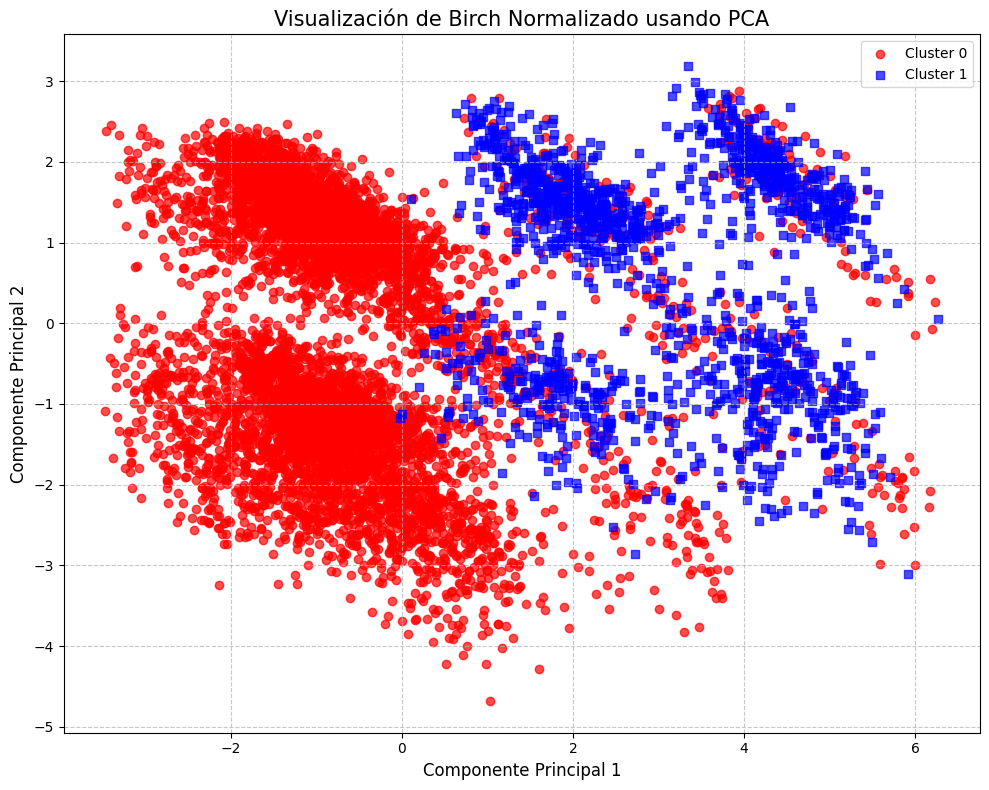

In [33]:
# Preparar los datos para PCA - solo usamos PCA para visualización
# Excluir la columna 'cluster' para el escalado
X = df_bc_N.drop('cluster', axis=1)

# Aplicar PCA para reducir a 2 dimensiones (solo para visualización)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

# Crear un DataFrame con los componentes principales
principal_df = pd.DataFrame(data=principalComponents, 
                           columns=['PC1', 'PC2'])

# Añadir la columna de cluster que ya teníamos
principal_df['cluster'] = df_bc_N['cluster']

# Visualizar los resultados proyectados en el espacio PCA
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange']
markers = ['o', 's', '^', 'D', 'v']

for i, color, marker in zip(range(len(np.unique(df_bc_N['cluster']))), colors, markers):
    plt.scatter(principal_df.loc[principal_df['cluster'] == i, 'PC1'],
                principal_df.loc[principal_df['cluster'] == i, 'PC2'],
                c=color, marker=marker, label=f'Cluster {i}', alpha=0.7)

plt.title('Visualización de Birch Normalizado usando PCA', fontsize=15)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Registrar la visualización en MLflow
with mlflow.start_run(experiment_id=exp_id, run_name="bc_K2_N_PCA_Visualization"):
    # Guardar la figura
    plt.savefig("../../../docs/graficos_modelado_clusterizacion/bc_k2_N_pca_visualization.png")
    mlflow.log_artifact("../../../docs/graficos_modelado_clusterizacion/bc_k2_N_pca_visualization.png", "visualizations")
    
    mlflow.end_run()

plt.show()

Prueba #3

In [34]:
# Se genera el experimento en mlflow
exp_name = 'Experimentación clustering #3 (Por documentar - vf)'
exp_id = mlflow.create_experiment(name=exp_name)

Se va a probar con el algoritmo de k-means con los datos normalizados:

    * k=4 (init='k-means++')

    * k=6 (init='k-means++')

    * GaussianMixture (GMM): 2, 4, 5 y 6 componentes.

Finalmente, con los datos sin normalizar con k=2 y con init = 'k-means++'.

In [35]:
# Por cada método se debe registrar la ejecución
with mlflow.start_run(experiment_id=exp_id, run_name="Kmeans N - K=4"):
    # Selección y configuración de la técnica
    modelo_clusters = KMeans(n_clusters=4, random_state = seed, init='k-means++')
    
    trained_model = modelo_clusters.fit(df_normalizado)
    cluster_labels = trained_model.labels_

    # Se realizar el cálculo de las métricas seleccionadas
    score_s = silhouette_score(df_normalizado, cluster_labels)
    score_db = davies_bouldin_score(df_normalizado, cluster_labels)
    score_ch = calinski_harabasz_score(df_normalizado, cluster_labels)

    # Se registra el parámetro K
    mlflow.log_param('Valor K', 4)
    mlflow.log_param('init', 'k-means++')

    # Se registran las métricas de evaluación
    mlflow.log_metric('silhouette_score', score_s)
    mlflow.log_metric('davies_bouldin_score', score_db)
    mlflow.log_metric('calinski_harabasz_score', score_ch)

    # Se guarda el modelo generado
    # input_example = df_normalizado.iloc[0].to_frame().T
    signature = infer_signature(df_normalizado, cluster_labels)
    mlflow.sklearn.log_model(trained_model, "Kmeans_K4_N", input_example=input_example, signature=signature)

    # Se finaliza el registro
    mlflow.end_run()

2025/05/07 13:42:59 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


In [36]:
# Se preserva el conjunto de datos original para evitar problemas
# Convertir df_normalizado a un DataFrame de pandas
df_kms_k4_n = pd.DataFrame(df_normalizado, columns=df.columns)

# Se agregan las labels generadas
df_kms_k4_n['cluster'] = cluster_labels

# Contar los elementos por cluster
df_kms_k4_n['cluster'].value_counts()

cluster
1    3526
0    3177
2    1588
3     587
Name: count, dtype: int64

c:\Users\Vero\Desktop\13MBID-OCT24-25\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


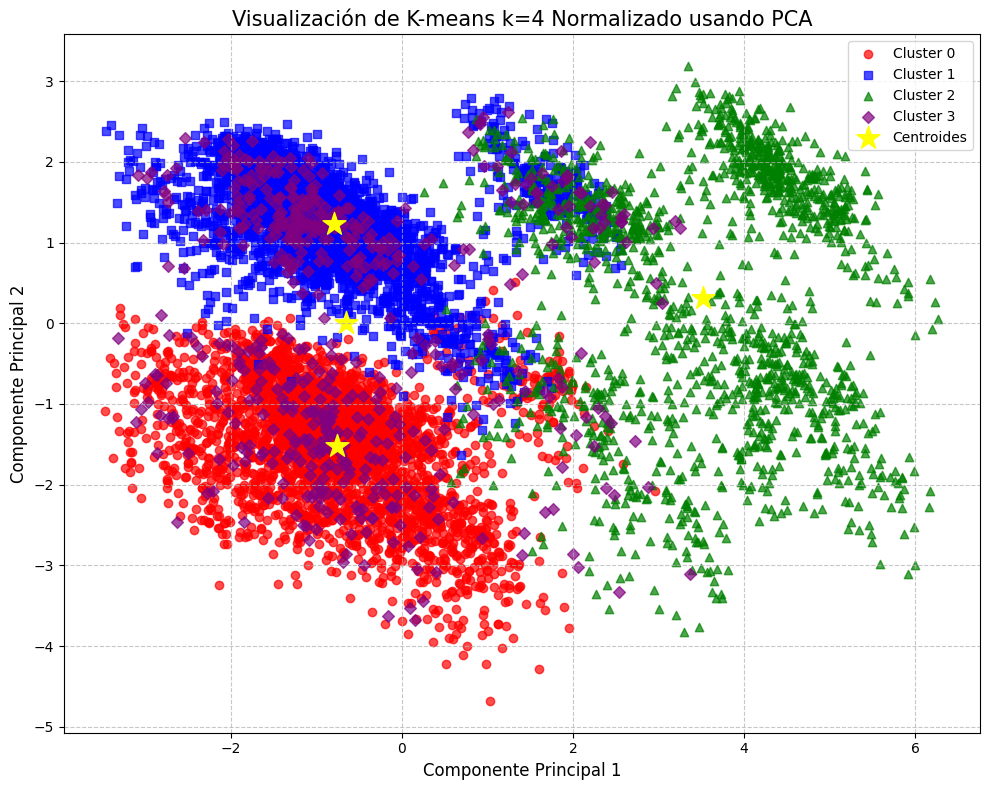

In [37]:
# Preparar los datos para PCA - solo usamos PCA para visualización
# Excluir la columna 'cluster' para el escalado
X = df_kms_k4_n.drop('cluster', axis=1)

# Aplicar PCA para reducir a 2 dimensiones (solo para visualización)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

# Crear un DataFrame con los componentes principales
principal_df = pd.DataFrame(data=principalComponents, 
                           columns=['PC1', 'PC2'])

# Añadir la columna de cluster que ya teníamos
principal_df['cluster'] = df_kms_k4_n['cluster']

# Visualizar los resultados proyectados en el espacio PCA
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange']
markers = ['o', 's', '^', 'D', 'v']

for i, color, marker in zip(range(len(np.unique(df_kms_k4_n['cluster']))), colors, markers):
    plt.scatter(principal_df.loc[principal_df['cluster'] == i, 'PC1'],
                principal_df.loc[principal_df['cluster'] == i, 'PC2'],
                c=color, marker=marker, label=f'Cluster {i}', alpha=0.7)

# Añadir centroides de K-means transformados al espacio PCA
centroids = pca.transform(modelo_clusters.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='yellow', marker='*', label='Centroides')


plt.title('Visualización de K-means k=4 Normalizado usando PCA', fontsize=15)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Registrar la visualización en MLflow
with mlflow.start_run(experiment_id=exp_id, run_name="Kmeans_K4_N_PCA_Visualization"):
    # Guardar la figura
    plt.savefig("../../../docs/graficos_modelado_clusterizacion/kmeans_k4_N_pca_visualization.png")
    mlflow.log_artifact("../../../docs/graficos_modelado_clusterizacion/kmeans_k4_N_pca_visualization.png", "visualizations")
    
    mlflow.end_run()

plt.show()

In [38]:
# Por cada método se debe registrar la ejecución
with mlflow.start_run(experiment_id=exp_id, run_name="Kmeans N - K=6"):
    # Selección y configuración de la técnica
    modelo_clusters = KMeans(n_clusters=6, init='k-means++', random_state = seed)
    
    trained_model = modelo_clusters.fit(df_normalizado)
    cluster_labels = trained_model.labels_

    # Se realizar el cálculo de las métricas seleccionadas
    score_s = silhouette_score(df_normalizado, cluster_labels)
    score_db = davies_bouldin_score(df_normalizado, cluster_labels)
    score_ch = calinski_harabasz_score(df_normalizado, cluster_labels)

    # Se registra el parámetro K
    mlflow.log_param('Valor K', 6)
    mlflow.log_param('init', 'k-means++')

    # Se registran las métricas de evaluación
    mlflow.log_metric('silhouette_score', score_s)
    mlflow.log_metric('davies_bouldin_score', score_db)
    mlflow.log_metric('calinski_harabasz_score', score_ch)

    # Se guarda el modelo generado
    # input_example = df_normalizado.iloc[0].to_frame().T
    signature = infer_signature(df_normalizado, cluster_labels)
    mlflow.sklearn.log_model(trained_model, "Kmeans_K6_N", input_example=input_example, signature=signature)

    # Se finaliza el registro
    mlflow.end_run()

2025/05/07 13:46:42 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


In [39]:
# Se preserva el conjunto de datos original para evitar problemas
# Convertir df_normalizado a un DataFrame de pandas
df_kms_k6_n = pd.DataFrame(df_normalizado, columns=df.columns)

# Se agregan las labels generadas
df_kms_k6_n['cluster'] = cluster_labels

# Contar los elementos por cluster
df_kms_k6_n['cluster'].value_counts()

cluster
4    2507
5    2250
1    1641
2    1493
3     554
0     433
Name: count, dtype: int64

c:\Users\Vero\Desktop\13MBID-OCT24-25\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


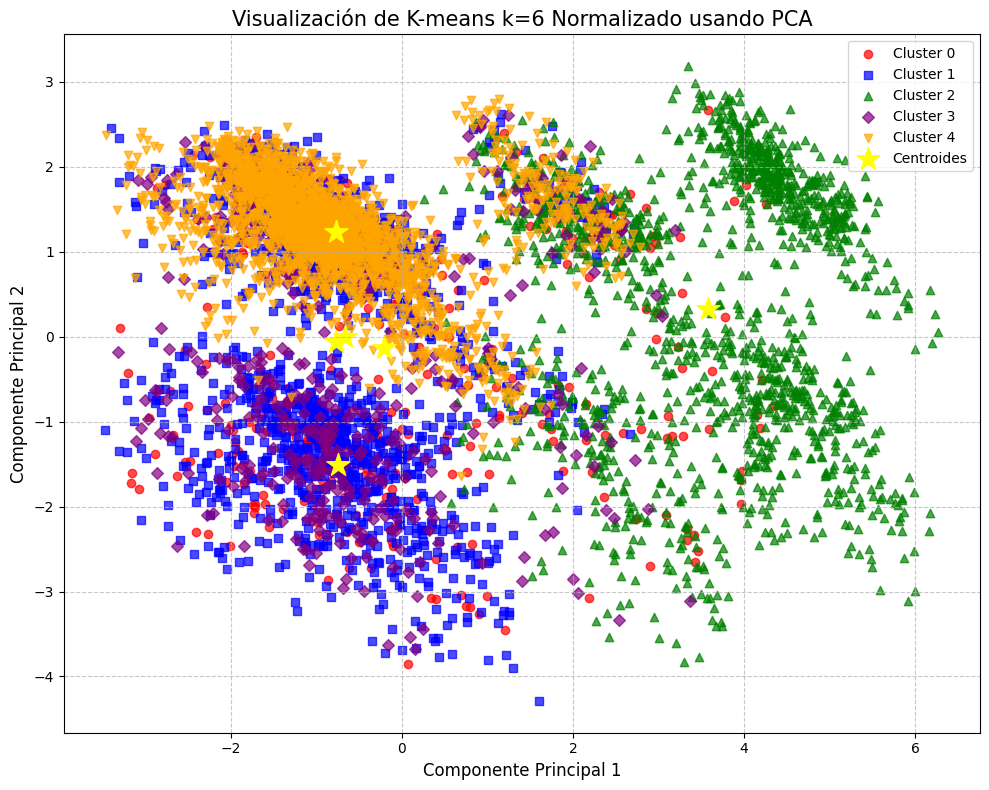

In [40]:
# Preparar los datos para PCA - solo usamos PCA para visualización
# Excluir la columna 'cluster' para el escalado
X = df_kms_k6_n.drop('cluster', axis=1)

# Aplicar PCA para reducir a 2 dimensiones (solo para visualización)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

# Crear un DataFrame con los componentes principales
principal_df = pd.DataFrame(data=principalComponents, 
                           columns=['PC1', 'PC2'])

# Añadir la columna de cluster que ya teníamos
principal_df['cluster'] = df_kms_k6_n['cluster']

# Visualizar los resultados proyectados en el espacio PCA
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange']
markers = ['o', 's', '^', 'D', 'v']

for i, color, marker in zip(range(len(np.unique(df_kms_k6_n['cluster']))), colors, markers):
    plt.scatter(principal_df.loc[principal_df['cluster'] == i, 'PC1'],
                principal_df.loc[principal_df['cluster'] == i, 'PC2'],
                c=color, marker=marker, label=f'Cluster {i}', alpha=0.7)

# Añadir centroides de K-means transformados al espacio PCA
centroids = pca.transform(modelo_clusters.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='yellow', marker='*', label='Centroides')


plt.title('Visualización de K-means k=6 Normalizado usando PCA', fontsize=15)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Registrar la visualización en MLflow
with mlflow.start_run(experiment_id=exp_id, run_name="Kmeans_K6_N_PCA_Visualization"):
    # Guardar la figura
    plt.savefig("../../../docs/graficos_modelado_clusterizacion/kmeans_k6_N_pca_visualization.png")
    mlflow.log_artifact("../../../docs/graficos_modelado_clusterizacion/kmeans_k6_N_pca_visualization.png", "visualizations")
    
    mlflow.end_run()

plt.show()

GMM

In [41]:
from sklearn.mixture import GaussianMixture

In [42]:
# Por cada método se debe registrar la ejecución
with mlflow.start_run(experiment_id=exp_id, run_name="GMM N - C=2"):
    # Selección y configuración de la técnica
    modelo_clusters = GaussianMixture(n_components=2, random_state=seed)
    
    trained_model = modelo_clusters.fit(df_normalizado)
    cluster_labels = trained_model.predict(df_normalizado)

    # Se realizar el cálculo de las métricas seleccionadas
    score_s = silhouette_score(df_normalizado, cluster_labels)
    score_db = davies_bouldin_score(df_normalizado, cluster_labels)
    score_ch = calinski_harabasz_score(df_normalizado, cluster_labels)

    # Se registra el parámetro de componentes
    mlflow.log_param('n_components', 2)
    mlflow.log_param('covariance_type', modelo_clusters.covariance_type)
    
    # Se registran las métricas de evaluación
    mlflow.log_metric('silhouette_score', score_s)
    mlflow.log_metric('davies_bouldin_score', score_db)
    mlflow.log_metric('calinski_harabasz_score', score_ch)
    mlflow.log_metric('bic', modelo_clusters.bic(df_normalizado))
    mlflow.log_metric('aic', modelo_clusters.aic(df_normalizado))

    # Se guarda el modelo generado
    signature = infer_signature(df_normalizado, cluster_labels)
    mlflow.sklearn.log_model(trained_model, "GMM_C2_N", input_example=input_example, signature=signature)

    # Se finaliza el registro
    mlflow.end_run()

2025/05/07 13:53:19 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


In [43]:
# Se preserva el conjunto de datos original para evitar problemas
# Convertir df_normalizado a un DataFrame de pandas
df_gmm_c2_n = pd.DataFrame(df_normalizado, columns=df.columns)

# Se agregan las labels generadas
df_gmm_c2_n['cluster'] = cluster_labels

# Contar los elementos por cluster
df_gmm_c2_n['cluster'].value_counts()

cluster
1    6789
0    2089
Name: count, dtype: int64

c:\Users\Vero\Desktop\13MBID-OCT24-25\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


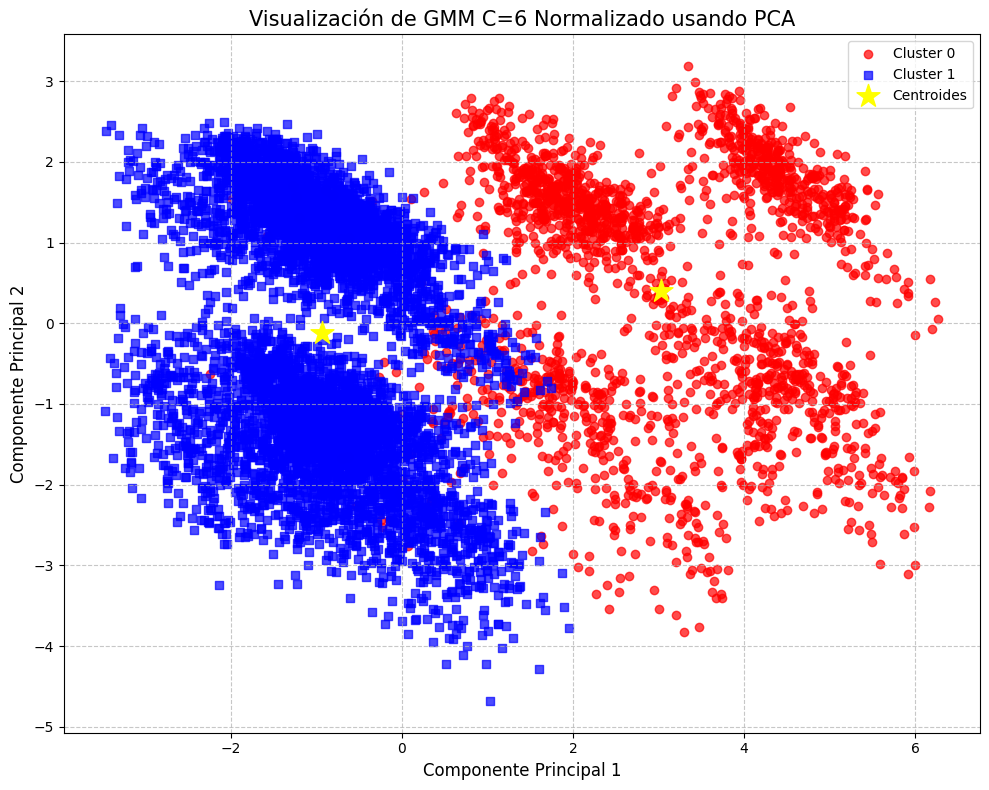

In [44]:
# Preparar los datos para PCA - solo usamos PCA para visualización
# Excluir la columna 'cluster' para el escalado
X = df_gmm_c2_n.drop('cluster', axis=1)

# Aplicar PCA para reducir a 2 dimensiones (solo para visualización)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

# Crear un DataFrame con los componentes principales
principal_df = pd.DataFrame(data=principalComponents, 
                           columns=['PC1', 'PC2'])

# Añadir la columna de cluster que ya teníamos
principal_df['cluster'] = df_gmm_c2_n['cluster']

# Visualizar los resultados proyectados en el espacio PCA
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan']
markers = ['o', 's', '^', 'D', 'v', 'P']

for i, color, marker in zip(range(len(np.unique(df_gmm_c2_n['cluster']))), colors, markers):
    plt.scatter(principal_df.loc[principal_df['cluster'] == i, 'PC1'],
                principal_df.loc[principal_df['cluster'] == i, 'PC2'],
                c=color, marker=marker, label=f'Cluster {i}', alpha=0.7)

# Añadir los centroides de GMM transformados al espacio PCA
centroids = pca.transform(modelo_clusters.means_)
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='yellow', marker='*', label='Centroides')

plt.title('Visualización de GMM C=6 Normalizado usando PCA', fontsize=15)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Registrar la visualización en MLflow
with mlflow.start_run(experiment_id=exp_id, run_name="GMM_C2_N_PCA_Visualization"):
    # Guardar la figura
    plt.savefig("../../../docs/graficos_modelado_clusterizacion/gmm_c2_N_pca_visualization.png")
    mlflow.log_artifact("../../../docs/graficos_modelado_clusterizacion/gmm_c2_N_pca_visualization.png", "visualizations")
    
    mlflow.end_run()

plt.show()

k=4

In [45]:
with mlflow.start_run(experiment_id=exp_id, run_name="GMM N - C=4"):
    # Selección y configuración de la técnica
    modelo_clusters = GaussianMixture(n_components=4, random_state=seed)
    
    trained_model = modelo_clusters.fit(df_normalizado)
    cluster_labels = trained_model.predict(df_normalizado)

    # Se realizar el cálculo de las métricas seleccionadas
    score_s = silhouette_score(df_normalizado, cluster_labels)
    score_db = davies_bouldin_score(df_normalizado, cluster_labels)
    score_ch = calinski_harabasz_score(df_normalizado, cluster_labels)

    # Se registra el parámetro de componentes
    mlflow.log_param('n_components', 4)
    mlflow.log_param('covariance_type', modelo_clusters.covariance_type)
    
    # Se registran las métricas de evaluación
    mlflow.log_metric('silhouette_score', score_s)
    mlflow.log_metric('davies_bouldin_score', score_db)
    mlflow.log_metric('calinski_harabasz_score', score_ch)
    mlflow.log_metric('bic', modelo_clusters.bic(df_normalizado))
    mlflow.log_metric('aic', modelo_clusters.aic(df_normalizado))

    # Se guarda el modelo generado
    signature = infer_signature(df_normalizado, cluster_labels)
    mlflow.sklearn.log_model(trained_model, "GMM_C4_N", input_example=input_example, signature=signature)

    # Se finaliza el registro
    mlflow.end_run()

2025/05/07 13:54:32 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


In [46]:
# Se preserva el conjunto de datos original para evitar problemas
# Convertir df_normalizado a un DataFrame de pandas
df_gmm_c4_n = pd.DataFrame(df_normalizado, columns=df.columns)

# Se agregan las labels generadas
df_gmm_c4_n['cluster'] = cluster_labels

# Contar los elementos por cluster
df_gmm_c4_n['cluster'].value_counts()

cluster
1    3576
0    3175
2    1464
3     663
Name: count, dtype: int64

c:\Users\Vero\Desktop\13MBID-OCT24-25\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


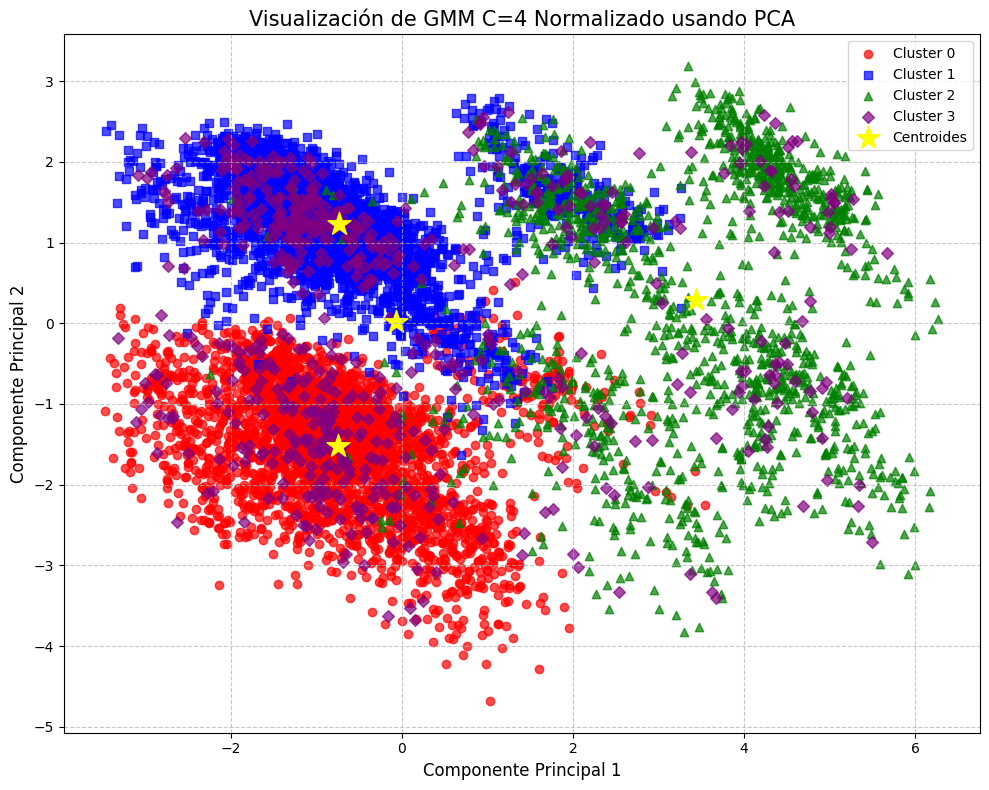

In [47]:
# Preparar los datos para PCA - solo usamos PCA para visualización
# Excluir la columna 'cluster' para el escalado
X = df_gmm_c4_n.drop('cluster', axis=1)

# Aplicar PCA para reducir a 2 dimensiones (solo para visualización)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

# Crear un DataFrame con los componentes principales
principal_df = pd.DataFrame(data=principalComponents, 
                           columns=['PC1', 'PC2'])

# Añadir la columna de cluster que ya teníamos
principal_df['cluster'] = df_gmm_c4_n['cluster']

# Visualizar los resultados proyectados en el espacio PCA
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan']
markers = ['o', 's', '^', 'D', 'v', 'P']

for i, color, marker in zip(range(len(np.unique(df_gmm_c4_n['cluster']))), colors, markers):
    plt.scatter(principal_df.loc[principal_df['cluster'] == i, 'PC1'],
                principal_df.loc[principal_df['cluster'] == i, 'PC2'],
                c=color, marker=marker, label=f'Cluster {i}', alpha=0.7)

# Añadir los centroides de GMM transformados al espacio PCA
centroids = pca.transform(modelo_clusters.means_)
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='yellow', marker='*', label='Centroides')

plt.title('Visualización de GMM C=4 Normalizado usando PCA', fontsize=15)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Registrar la visualización en MLflow
with mlflow.start_run(experiment_id=exp_id, run_name="GMM_C4_N_PCA_Visualization"):
    # Guardar la figura
    plt.savefig("../../../docs/graficos_modelado_clusterizacion/gmm_c4_N_pca_visualization.png")
    mlflow.log_artifact("../../../docs/graficos_modelado_clusterizacion/gmm_c4_N_pca_visualization.png", "visualizations")
    
    mlflow.end_run()

plt.show()

k=6

In [ ]:
with mlflow.start_run(experiment_id=exp_id, run_name="GMM N - C=6"):
    # Selección y configuración de la técnica
    modelo_clusters = GaussianMixture(n_components=6, random_state=seed)
    
    trained_model = modelo_clusters.fit(df_normalizado)
    cluster_labels = trained_model.predict(df_normalizado)

    # Se realizar el cálculo de las métricas seleccionadas
    score_s = silhouette_score(df_normalizado, cluster_labels)
    score_db = davies_bouldin_score(df_normalizado, cluster_labels)
    score_ch = calinski_harabasz_score(df_normalizado, cluster_labels)

    # Se registra el parámetro de componentes
    mlflow.log_param('n_components', 6)
    mlflow.log_param('covariance_type', modelo_clusters.covariance_type)
    
    # Se registran las métricas de evaluación
    mlflow.log_metric('silhouette_score', score_s)
    mlflow.log_metric('davies_bouldin_score', score_db)
    mlflow.log_metric('calinski_harabasz_score', score_ch)
    mlflow.log_metric('bic', modelo_clusters.bic(df_normalizado))
    mlflow.log_metric('aic', modelo_clusters.aic(df_normalizado))

    # Se guarda el modelo generado
    signature = infer_signature(df_normalizado, cluster_labels)
    mlflow.sklearn.log_model(trained_model, "GMM_C6_N", input_example=input_example, signature=signature)

    # Se finaliza el registro
    mlflow.end_run()

2025/05/07 13:55:58 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


cluster
4    2528
5    2244
1    1633
2    1386
3     627
0     460
Name: count, dtype: int64

In [49]:
# Se preserva el conjunto de datos original para evitar problemas
# Convertir df_normalizado a un DataFrame de pandas
df_gmm_c6_n = pd.DataFrame(df_normalizado, columns=df.columns)

# Se agregan las labels generadas
df_gmm_c6_n['cluster'] = cluster_labels

# Contar los elementos por cluster
df_gmm_c6_n['cluster'].value_counts()

cluster
4    2528
5    2244
1    1633
2    1386
3     627
0     460
Name: count, dtype: int64

c:\Users\Vero\Desktop\13MBID-OCT24-25\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


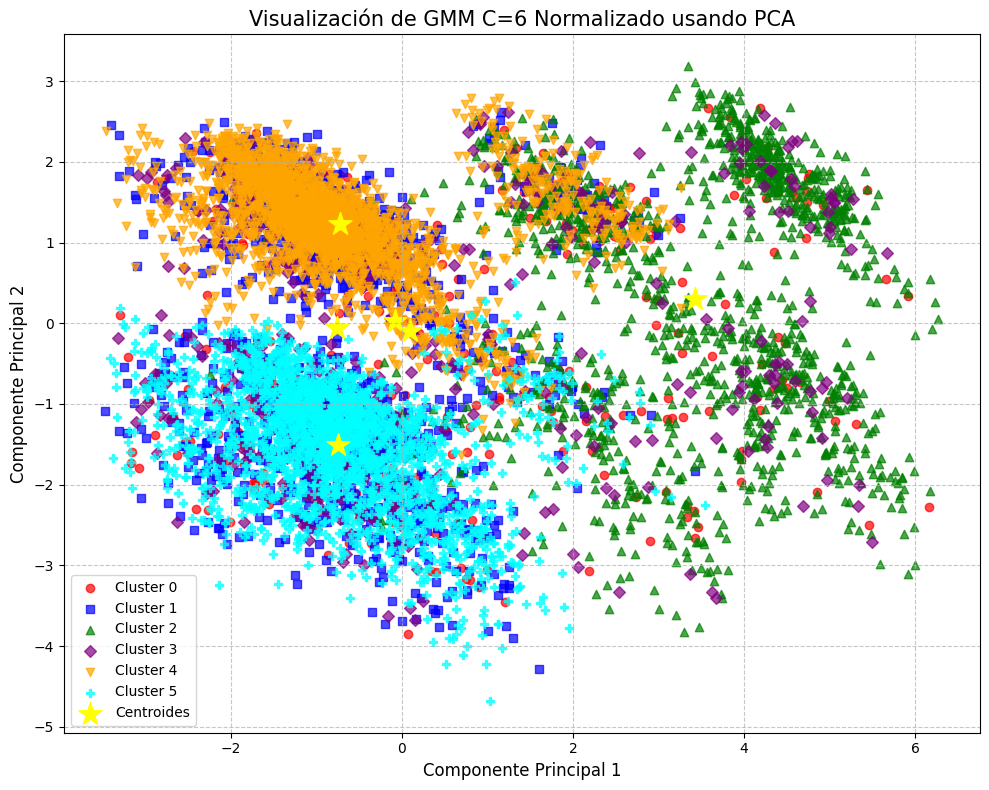

In [50]:
# Preparar los datos para PCA - solo usamos PCA para visualización
# Excluir la columna 'cluster' para el escalado
X = df_gmm_c6_n.drop('cluster', axis=1)

# Aplicar PCA para reducir a 2 dimensiones (solo para visualización)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

# Crear un DataFrame con los componentes principales
principal_df = pd.DataFrame(data=principalComponents, 
                           columns=['PC1', 'PC2'])

# Añadir la columna de cluster que ya teníamos
principal_df['cluster'] = df_gmm_c6_n['cluster']

# Visualizar los resultados proyectados en el espacio PCA
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan']
markers = ['o', 's', '^', 'D', 'v', 'P']

for i, color, marker in zip(range(len(np.unique(df_gmm_c6_n['cluster']))), colors, markers):
    plt.scatter(principal_df.loc[principal_df['cluster'] == i, 'PC1'],
                principal_df.loc[principal_df['cluster'] == i, 'PC2'],
                c=color, marker=marker, label=f'Cluster {i}', alpha=0.7)

# Añadir los centroides de GMM transformados al espacio PCA
centroids = pca.transform(modelo_clusters.means_)
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='yellow', marker='*', label='Centroides')

plt.title('Visualización de GMM C=6 Normalizado usando PCA', fontsize=15)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Registrar la visualización en MLflow
with mlflow.start_run(experiment_id=exp_id, run_name="GMM_C6_N_PCA_Visualization"):
    # Guardar la figura
    plt.savefig("../../../docs/graficos_modelado_clusterizacion/gmm_c6_N_pca_visualization.png")
    mlflow.log_artifact("../../../docs/graficos_modelado_clusterizacion/gmm_c6_N_pca_visualization.png", "visualizations")
    
    mlflow.end_run()

plt.show()

k=5

In [51]:
with mlflow.start_run(experiment_id=exp_id, run_name="GMM N - C=5"):
    # Selección y configuración de la técnica
    modelo_clusters = GaussianMixture(n_components=5, random_state=seed)
    
    trained_model = modelo_clusters.fit(df_normalizado)
    cluster_labels = trained_model.predict(df_normalizado)

    # Se realizar el cálculo de las métricas seleccionadas
    score_s = silhouette_score(df_normalizado, cluster_labels)
    score_db = davies_bouldin_score(df_normalizado, cluster_labels)
    score_ch = calinski_harabasz_score(df_normalizado, cluster_labels)

    # Se registra el parámetro de componentes
    mlflow.log_param('n_components', 5)
    mlflow.log_param('covariance_type', modelo_clusters.covariance_type)
    
    # Se registran las métricas de evaluación
    mlflow.log_metric('silhouette_score', score_s)
    mlflow.log_metric('davies_bouldin_score', score_db)
    mlflow.log_metric('calinski_harabasz_score', score_ch)
    mlflow.log_metric('bic', modelo_clusters.bic(df_normalizado))
    mlflow.log_metric('aic', modelo_clusters.aic(df_normalizado))

    # Se guarda el modelo generado
    signature = infer_signature(df_normalizado, cluster_labels)
    mlflow.sklearn.log_model(trained_model, "GMM_C5_N", input_example=input_example, signature=signature)

    # Se finaliza el registro
    mlflow.end_run()

2025/05/07 14:00:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


In [52]:
# Se preserva el conjunto de datos original para evitar problemas
# Convertir df_normalizado a un DataFrame de pandas
df_gmm_c5_n = pd.DataFrame(df_normalizado, columns=df.columns)

# Se agregan las labels generadas
df_gmm_c5_n['cluster'] = cluster_labels

# Contar los elementos por cluster
df_gmm_c5_n['cluster'].value_counts()

cluster
4    2709
0    2409
1    1633
2    1464
3     663
Name: count, dtype: int64

c:\Users\Vero\Desktop\13MBID-OCT24-25\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


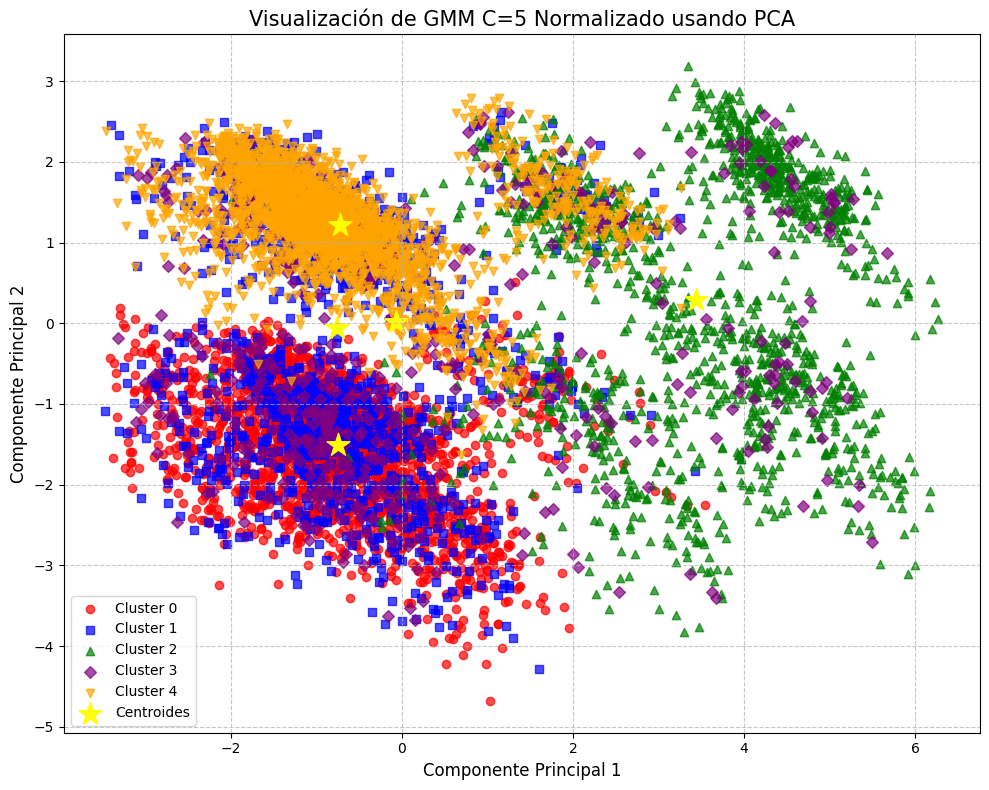

In [53]:
# Preparar los datos para PCA - solo usamos PCA para visualización
# Excluir la columna 'cluster' para el escalado
X = df_gmm_c5_n.drop('cluster', axis=1)

# Aplicar PCA para reducir a 2 dimensiones (solo para visualización)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

# Crear un DataFrame con los componentes principales
principal_df = pd.DataFrame(data=principalComponents, 
                           columns=['PC1', 'PC2'])

# Añadir la columna de cluster que ya teníamos
principal_df['cluster'] = df_gmm_c5_n['cluster']

# Visualizar los resultados proyectados en el espacio PCA
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange']
markers = ['o', 's', '^', 'D', 'v']

for i, color, marker in zip(range(len(np.unique(df_gmm_c5_n['cluster']))), colors, markers):
    plt.scatter(principal_df.loc[principal_df['cluster'] == i, 'PC1'],
                principal_df.loc[principal_df['cluster'] == i, 'PC2'],
                c=color, marker=marker, label=f'Cluster {i}', alpha=0.7)

# Añadir los centroides de GMM transformados al espacio PCA
centroids = pca.transform(modelo_clusters.means_)
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='yellow', marker='*', label='Centroides')

plt.title('Visualización de GMM C=5 Normalizado usando PCA', fontsize=15)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Registrar la visualización en MLflow
with mlflow.start_run(experiment_id=exp_id, run_name="GMM_C5_N_PCA_Visualization"):
    # Guardar la figura
    plt.savefig("../../../docs/graficos_modelado_clusterizacion/gmm_c5_N_pca_visualization.png")
    mlflow.log_artifact("../../../docs/graficos_modelado_clusterizacion/gmm_c5_N_pca_visualization.png", "visualizations")
    
    mlflow.end_run()

plt.show()

Las métricas no son mejores. Por lo que se prueba con k-means con init='k-means++' para k=2 sin normalizar.

In [54]:
# Por cada método se debe registrar la ejecución
with mlflow.start_run(experiment_id=exp_id, run_name="Kmeans - K=2"):
    # Selección y configuración de la técnica
    modelo_clusters = KMeans(n_clusters=2, random_state = seed, init='k-means++')
    
    trained_model = modelo_clusters.fit(df)
    cluster_labels = trained_model.labels_

    # Se realizar el cálculo de las métricas seleccionadas
    score_s = silhouette_score(df, cluster_labels)
    score_db = davies_bouldin_score(df, cluster_labels)
    score_ch = calinski_harabasz_score(df, cluster_labels)

    # Se registra el parámetro K
    mlflow.log_param('Valor K', 2)
    mlflow.log_param('init', 'k-means++')

    # Se registran las métricas de evaluación
    mlflow.log_metric('silhouette_score', score_s)
    mlflow.log_metric('davies_bouldin_score', score_db)
    mlflow.log_metric('calinski_harabasz_score', score_ch)

    # Se guarda el modelo generado
    input_example = df.iloc[0].to_frame().T
    signature = infer_signature(df, cluster_labels)
    mlflow.sklearn.log_model(trained_model, "Kmeans_K2_++", input_example=input_example, signature=signature)

    # Se finaliza el registro
    mlflow.end_run()

2025/05/07 15:42:29 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


In [55]:
# Se preserva el conjunto de datos original para evitar problemas
df_kmeans_k2_plus = df.copy()
# Se agregan las labels generadas
df_kmeans_k2_plus['cluster'] = cluster_labels
df_kmeans_k2_plus['cluster'].value_counts()

cluster
0    8276
1     602
Name: count, dtype: int64

c:\Users\Vero\Desktop\13MBID-OCT24-25\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


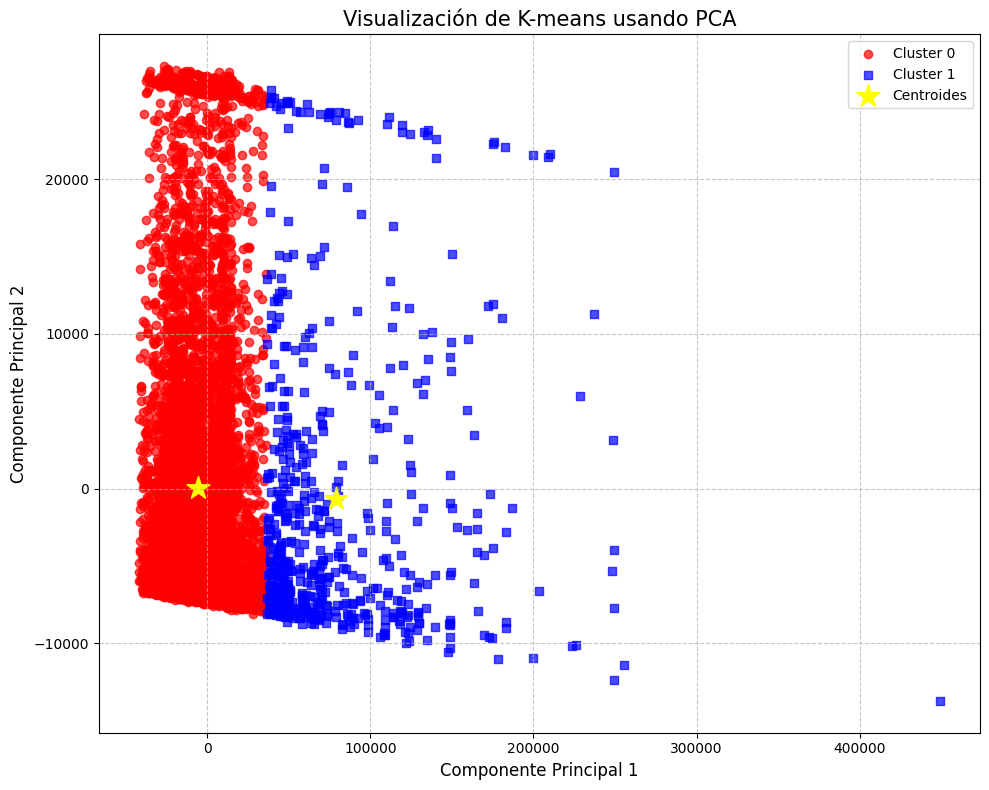

In [56]:
# Preparar los datos para PCA - solo usamos PCA para visualización
# Excluir la columna 'cluster' para el escalado
X = df_kmeans_k2_plus.drop('cluster', axis=1)

# Aplicar PCA para reducir a 2 dimensiones (solo para visualización)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

# Crear un DataFrame con los componentes principales
principal_df = pd.DataFrame(data=principalComponents, 
                           columns=['PC1', 'PC2'])

# Añadir la columna de cluster que ya teníamos
principal_df['cluster'] = df_kmeans_k2_plus['cluster']

# Visualizar los resultados proyectados en el espacio PCA
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange']
markers = ['o', 's', '^', 'D', 'v']

for i, color, marker in zip(range(len(np.unique(df_kmeans_k2_plus['cluster']))), colors, markers):
    plt.scatter(principal_df.loc[principal_df['cluster'] == i, 'PC1'],
                principal_df.loc[principal_df['cluster'] == i, 'PC2'],
                c=color, marker=marker, label=f'Cluster {i}', alpha=0.7)

# Añadir centroides de K-means transformados al espacio PCA
centroids = pca.transform(modelo_clusters.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='yellow', marker='*', label='Centroides')


plt.title('Visualización de K-means usando PCA', fontsize=15)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Registrar la visualización en MLflow
with mlflow.start_run(experiment_id=exp_id, run_name="Kmeans_K2_++_PCA_Visualization"):
    # Guardar la figura
    plt.savefig("../../../docs/graficos_modelado_clusterizacion/kmeans_k2_++_pca_visualization.png")
    mlflow.log_artifact("../../../docs/graficos_modelado_clusterizacion/kmeans_k2_++_pca_visualization.png", "visualizations")
    
    mlflow.end_run()

plt.show()

----
Datos finales a exportar

In [57]:
# Se genera el experimento en mlflow
exp_name = 'Experimentación clustering FINAL (Por documentar - vf)'
exp_id = mlflow.create_experiment(name=exp_name)

In [58]:
# Por cada método se debe registrar la ejecución
with mlflow.start_run(experiment_id=exp_id, run_name="Kmeans - K=2"):
    # Selección y configuración de la técnica
    modelo_clusters = KMeans(n_clusters=2, random_state = seed)
    
    trained_model = modelo_clusters.fit(df)
    cluster_labels = trained_model.labels_

    # Se realizar el cálculo de las métricas seleccionadas
    score_s = silhouette_score(df, cluster_labels)
    score_db = davies_bouldin_score(df, cluster_labels)
    score_ch = calinski_harabasz_score(df, cluster_labels)

    # Se registra el parámetro K
    mlflow.log_param('Valor K', 2)

    # Se registran las métricas de evaluación
    mlflow.log_metric('silhouette_score', score_s)
    mlflow.log_metric('davies_bouldin_score', score_db)
    mlflow.log_metric('calinski_harabasz_score', score_ch)

    # Se guarda el modelo generado
    input_example = df.iloc[0].to_frame().T
    signature = infer_signature(df, cluster_labels)
    mlflow.sklearn.log_model(trained_model, "Kmeans_K2", input_example=input_example, signature=signature)

    # Se finaliza el registro
    mlflow.end_run()

2025/05/07 17:13:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Se realiza la exportacion de los resultados finales

In [59]:
# Se preserva el conjunto de datos original para evitar problemas
df_kmeans_k2 = df.copy()
# Se agregan las labels generadas
df_kmeans_k2['cluster'] = cluster_labels
df_kmeans_k2['cluster'].value_counts()

cluster
0    8276
1     602
Name: count, dtype: int64

In [60]:
df_kmeans_k2.to_csv("../../../data/final/df_kms_k2.csv", sep=";", index=False)

In [61]:
# Por cada método se debe registrar la ejecución
with mlflow.start_run(experiment_id=exp_id, run_name="AGClustering - K=2"):
    # Selección y configuración de la técnica
    modelo_clusters = AgglomerativeClustering(n_clusters=2)
    
    trained_model = modelo_clusters.fit(df)
    cluster_labels = trained_model.labels_

    # Se realizar el cálculo de las métricas seleccionadas
    score_s = silhouette_score(df, cluster_labels)
    score_db = davies_bouldin_score(df, cluster_labels)
    score_ch = calinski_harabasz_score(df, cluster_labels)

    # Se registra el parámetro K
    mlflow.log_param('Valor K', 2)

    # Se registran las métricas de evaluación
    mlflow.log_metric('silhouette_score', score_s)
    mlflow.log_metric('davies_bouldin_score', score_db)
    mlflow.log_metric('calinski_harabasz_score', score_ch)

    # Se guarda el modelo generado
    # input_example = df.iloc[0].to_frame().T
    signature = infer_signature(df, cluster_labels)
    mlflow.sklearn.log_model(trained_model, "AGC_2", signature=signature)

    # Se finaliza el registro
    mlflow.end_run()

2025/05/07 17:14:08 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/05/07 17:14:17 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


In [62]:
# Se preserva el conjunto de datos original para evitar problemas
df_agc_k2 = df.copy()
# Se agregan las labels generadas
df_agc_k2['cluster'] = cluster_labels
df_agc_k2['cluster'].value_counts()

cluster
0    8508
1     370
Name: count, dtype: int64

In [64]:
df_agc_k2.to_csv("../../../data/final/df_agc_k2.csv", sep=";", index=False)